# Time‑Accurate XV‑15 rotor

This notebook walks through a **time‑accurate** setup for the XV‑15 using Flow360. The geometry consists of an isolated rotor from the XV-15 rotorcraft with a sliding interface around it. The farfield zone is cylindrical around the rotor and the rotating zone.

<p align="center">
<img src="rotInterfaceView.png" alt="Airfoil geometry" width="30%">
</p>

## 1. Create Project from Volume Mesh
- Load Python libraries and Flow360 client. If you use environment variables or tokens, initialize them here so later API calls can authenticate. XV15 data files are loaded here.
- Project is created from the volume mesh

In [15]:
import flow360 as fl
from flow360.examples import TutorialRANSXv15
import matplotlib.pyplot as plt

TutorialRANSXv15.get_files()
project = fl.Project.from_volume_mesh(
    TutorialRANSXv15.mesh_filename,
    name="Tutorial Time-accurate RANS CFD on XV-15 from Python",
)
volume_mesh = project.volume_mesh

Output()

Output()

[09:33:51] INFO: VolumeMesh successfully submitted:                                                                
                   type   = Volume Mesh                                                                            
                   name   = Tutorial Time-accurate RANS CFD on XV-15 from Python                                   
                   id     = vm-c6bb510f-e780-430a-8a14-56920a5dbfde                                                
                   status = uploaded                                                                               
           

Output()

## 2. Define rotating zone
The following steps are needed to use a rotating zone:
- The volume zone 'innerRotating' is defined with a center and axis of rotation.
- The rotating model is defined with the rotating zone and the angular velocity.

In [16]:
with fl.SI_unit_system:
    rotation_zone = volume_mesh["innerRotating"]
    rotation_zone.center = (0, 0, 0) * fl.u.m
    rotation_zone.axis = (0, 0, -1)

    rotation_model = fl.Rotation(
        volumes=rotation_zone,
        spec=fl.AngularVelocity(600 * fl.u.rpm),
    )

[09:34:07] INFO: using: SI unit system for unit inference.

## 3. Define time and DDES settings
To use a time accurate numerical setup with sliding interface, the time settings need to be specified as unsteady. 
For simulation, we will do 5 revolutions at 3 ° per time step, thus 600 physical time steps in total

In [17]:
time_model = fl.Unsteady(
    max_pseudo_steps=35,
    steps=600,
    step_size=0.5 / 600 * fl.u.s,
    CFL=fl.AdaptiveCFL(),
)

## 4. DDES settings

To use DDES, the turbulence model needs to be defined as such:

In [18]:
ddes_model = fl.SpalartAllmaras(
    absolute_tolerance=1e-8,
    linear_solver=fl.LinearSolver(max_iterations=25),
    hybrid_model=fl.DetachedEddySimulation(shielding_function="DDES"),
    rotation_correction=True,
    equation_evaluation_frequency=1,
)

## 5. Define SimulationParams
- The simulation parameters are defined in the python class fl.SimulationParams()
- Reference geometry for the non-dimensionalisation of the coefficients are specified
- Operating conditions are specified in SI units. For our case we have the following operating conditions:
    - Airspeed = 5 m/s
    - Rotation rate = 600 RPM
    - Speed of sound = 340.2 m/s
    - Density = 1.225 kg/m3
    - Alpha = -90 °, air coming down from above (i.e., an ascent case)

Other key considerations:

The reference velocity magnitude is arbitrarily set to the tip velocity magnitude of the blades, with an estimated M = 0.7 (238.14 m/s)

In [19]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        reference_geometry=fl.ReferenceGeometry(
            moment_center=(0, 0, 0),
            moment_length=(3.81, 3.81, 3.81),
            area=45.604,
        ),
        operating_condition=fl.AerospaceCondition(
            velocity_magnitude=5,
            alpha=-90 * fl.u.deg,
            reference_velocity_magnitude=238.14,
        ),
        time_stepping=time_model,
        models=[
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(
                    absolute_tolerance=1e-9,
                    linear_solver=fl.LinearSolver(max_iterations=35),
                    limit_velocity=True,
                    limit_pressure_density=True,
                ),
                turbulence_model_solver=ddes_model,
            ),
            fl.Freestream(surfaces=volume_mesh["farField/farField"]),
            fl.Wall(surfaces=volume_mesh["innerRotating/blade"]),
            rotation_model,
        ],
        outputs=[
            fl.VolumeOutput(
                output_fields=[
                    "primitiveVars",
                    "T",
                    "Cp",
                    "Mach",
                    "qcriterion",
                    "VelocityRelative",
                ],
            ),
            fl.SurfaceOutput(
                surfaces=volume_mesh["*"],
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "Cf",
                    "CfVec",
                    "yPlus",
                    "nodeForcesPerUnitArea",
                ],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 6. Run Case
Run the case specifing parameters and the case name.

In [20]:
case = project.run_case(
    params=params,
    name="Tutorial Time-accurate DDES CFD on XV-15 from Python",
)

           INFO: using: SI unit system for unit inference.

[09:34:09] INFO: Successfully submitted:                                                                           
                   type   = Case                                                                                   
                   name   = Tutorial Time-accurate DDES CFD on XV-15 from Python                                   
                   id     = case-f18313c0-cd0d-416f-8856-959c55ef43ec                                              
                   status = pending                                                                                
           

## 7. Post Processing
Once the simulation is finished, we will monitor the convergence of forces and residuals.

Output()

Output()

[09:46:17] INFO: Saved to /tmp/tmpo9zf1vfg/8af2561c-0dc8-45ae-bc74-456b1f0e37c8.csv

Output()

[09:46:19] INFO: Saved to /tmp/tmpo9zf1vfg/5bb3c7c7-8f1f-492e-9f2a-5b99e123bb1b.csv

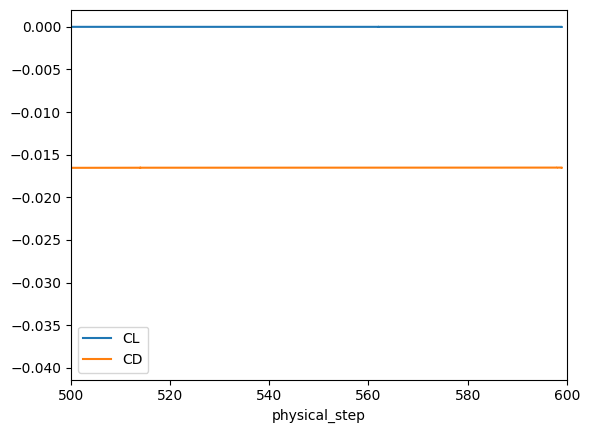

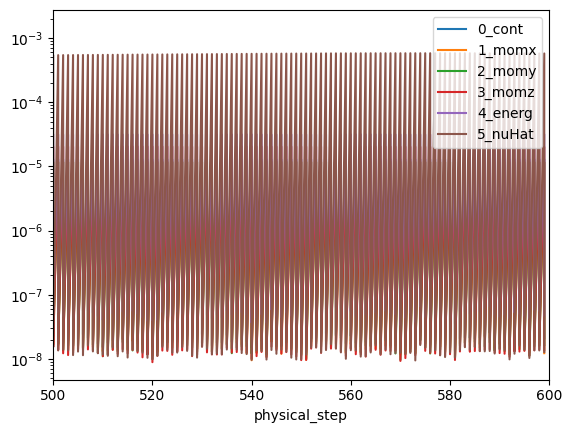

In [ ]:
case.wait()
results = case.results

total_forces = case.results.total_forces.as_dataframe()
total_forces.plot("physical_step", ["CL", "CD"])

non_linear = case.results.nonlinear_residuals.as_dataframe()
non_linear.plot("physical_step", ["0_cont","1_momx","2_momy","3_momz","4_energ","5_nuHat"], logy=True)
plt.xlim(550, 600)
plt.show()